# Image Completion

## Import packages

In [10]:
import sys
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("..")) # Add the parent directory to the system path

from data_completion_python import maxvol, matrix_completion, utils

## Low-Rank Matrix Completion

We will demonstrate how missing data can be recovered using low-rank matrix completion.

As an example, we will use this image of a house as an example.

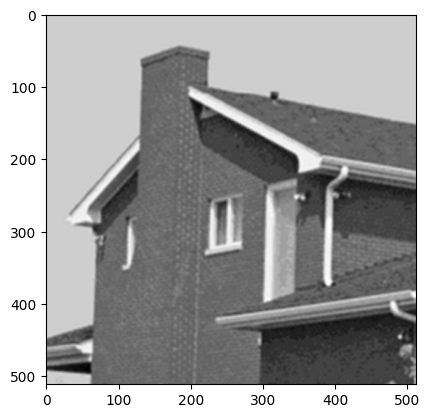

In [11]:
# Read house image
house_img = Image.open('../images/input/house.png').convert('L')
plt.imshow(house_img, cmap='grey')
plt.show()

### Delete Data

35% of the data will be deleted at random.

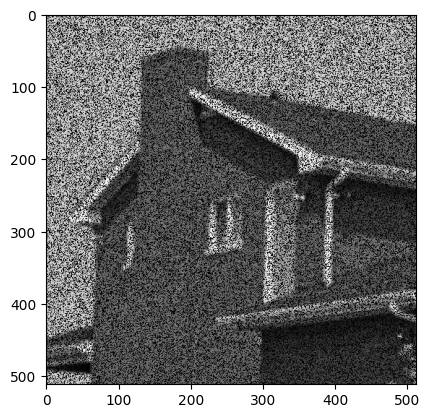

In [12]:
house_array = np.array(house_img)
m, n = np.shape(house_array) # dimensions of image
known_ratio = 0.65 # percentage of known entries
num_known = round(known_ratio * m * n) # number of known entries
house_mask = utils.random_mask(m, n, num_known)
house_missing_data = house_array.copy()
house_missing_data[~house_mask] = 0
plt.imshow(house_missing_data, cmap='grey')
plt.show()

### Alternating Projection

Complete the house image using the alternating projection method.

In [13]:
rank = int(min(m, n)/15)
alt_proj_house_completion = matrix_completion.alternating_projection(house_missing_data, house_mask, rank)

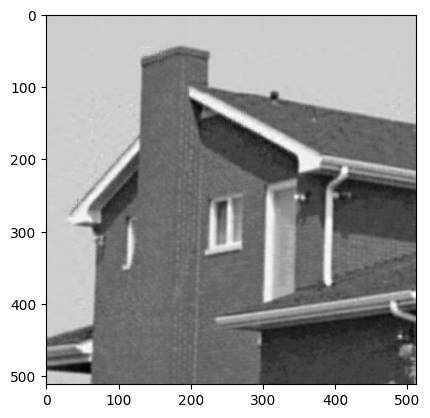

In [14]:
plt.imshow(alt_proj_house_completion, cmap='grey', vmin=0, vmax=255)
plt.show()

## Maximum Volume Algorithms

Maximum volume algorithms find close to maximum volume submatrices of a matrix. Here the volume of a matrix is the absolute value of the determinant.

Maximum volume submatrices are important to find because they minimize the error of the CUR decomposition of the matrix if they matrix is high rank.

### Random Submatrix

To demonstrate the effectiveness of using a maximum volume submatrix for the CUR decomposition, we will take the CUR decomposition with respect to an arbitrary submatrix, which will result in an approximation with extremely high noise.

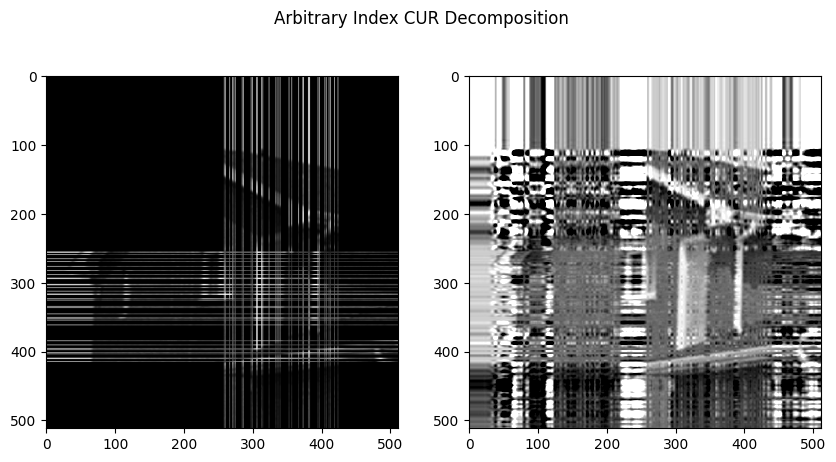

In [19]:
I_random = np.random.choice(m//3, rank, replace=False) + m//2 # random row indices
J_random = np.random.choice(n//3, rank, replace=False) + n//2 # random column indices

random_deletion = utils.forget_compliment(house_array, I_random, J_random)
cur_random = maxvol.cur_decomposition(house_array, I_random, J_random)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
fig.suptitle('Arbitrary Index CUR Decomposition')
axes[0].imshow(random_deletion, cmap='grey', vmin=0, vmax=255)
axes[1].imshow(cur_random, cmap='grey', vmin=0, vmax=255)
plt.show()

### Maximum Volumne Submatrix

Now we will take the CUR decomposition with respect to a maximum volume submatrix. This approximation is much closer to the original image than the arbitrary CUR decomposition is. 

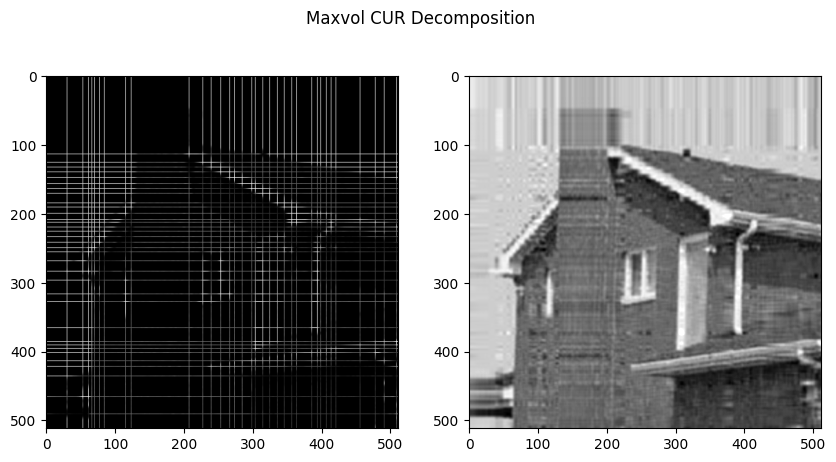

In [23]:
I_maxvol, J_maxvol = maxvol.alternating_maxvol(house_array, I_random, J_random)

maxvol_deletion = utils.forget_compliment(house_array, I_maxvol, J_maxvol)
cur_maxvol = maxvol.cur_decomposition(house_array, I_maxvol, J_maxvol)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
fig.suptitle('Maxvol CUR Decomposition')
axes[0].imshow(maxvol_deletion, cmap='grey', vmin=0, vmax=255)
axes[1].imshow(cur_maxvol, cmap='grey', vmin=0, vmax=255)
plt.show()

### Error

The peak signal to nosie ratio of the CUR decomposition is much better when taken with respect to a maximum volume submatrix.

In [24]:
random_approx_psnr = utils.psnr(cur_random, house_array)
maxvol_approx_psnr = utils.psnr(cur_maxvol, house_array)
print(f"The PSNR (peak signal to nosie ratio) of the CUR approximation with respect to a maximum volumne submatrix is {maxvol_approx_psnr}.")
print(f"The PSNR of the CUR approximation with respect to a random submatrix is {random_approx_psnr}.")

The PSNR (peak signal to nosie ratio) of the CUR approximation with respect to a maximum volumne submatrix is 25.260542698400847.
The PSNR of the CUR approximation with respect to a random submatrix is 5.433005750830634.
